# Simon's Algorithm

Given a function with a parameter s (bitstring), it is guaranteed that for x = y, where y = x $\oplus$ s, then f(x) = f(y)\
that is to say that f is 2-to-1. (for every ouput there are 2 different inputs that map to that ouput)\
Note, that if b = 0$\dots$0 i.e. 0 bitstring the function f is 1-to-1 because for f(x) = f(y) we have x = y

## Imports and Definitions

In [1]:
import numpy as np
from math import sqrt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
from random import randint

unitary_backend = Aer.get_backend("unitary_simulator")
statevector_backend = Aer.get_backend("statevector_simulator")
backend = Aer.get_backend("qasm_simulator")

## General Simon Oracle

Given a bitstring s we want to create an oracle that maps the state $\lvert x \rangle \lvert 0 \rangle$ to the state $\lvert x \rangle \lvert f_s(x) \rangle$\
We do this by copying the first register onto the second and xoring the second register with s.

In [6]:
def simon_oracle(s):
    """
    Returns a 2*n qubit gate wich maps |x>|0> to |x>|f(x)>
    """
    n = len(s)
    
    qc = QuantumCircuit(2 * n)
    
    for q in range(n):
        qc.cx(q, n + q)
        
    for i in range(n):
        if s[i] == "1":
            qc.cx(i, n + i)
    
    nr_swaps = randint(0, n)
    for i in range(nr_swaps):
        x = randint(n, 2 * n - 1)
        y = randint(n, 2 * n - 1)
        if x != y:
            qc.swap(x, y)
    
#     perm = Permutation(n).to_gate()
#     qc.append(perm, range(n, 2 * n))
    oracle = qc.to_gate()
    oracle.name = "Simon Oracle"
    return oracle

# Simon's Algorithm

Here is a implementation of a simon circuit which gives us a z so that $z \cdot s = 0 \bmod 2$

In [12]:
def simon_circuit(s):
    """
    Creates a simon oracle based on the given bitstring s
    and applies simon's algorithm
    Returns the resulting circuit
    """
    
    n = len(s)
    oracle = simon_oracle(s)
    
    # we need a qc with 2 quantum registers each with n qubits
    # and 2 classical registers also with n bits for the measurements
    qc = QuantumCircuit(2 * n, n)
    
    # apply H on the first register => |x>|0>
    for q in range(n):
        qc.h(q)
    qc.barrier()
    
    
    # apply the oracle => |x>|f(x)>
    qc.append(oracle, range(2 * n))
    qc.barrier()
    
    # measure the second register
    # results in a change of the first register (superposition of x and y where f(x) = f(y))
#     for q in range(n, 2 * n):
#         qc.measure(q, q)
#     qc.barrier()
        
    # perform fourier sampling on the first register
    for q in range(n):
        qc.h(q)
    
    for q in range(n):
        qc.measure(q, q)
    
    # What will be measured in the first classical register is a bitstring z so that z dot b = 0 (mod 2)
    
    return qc

If we run the circuit above n times we will get $z_1, z_2 \dots , z_n$\
With these we can build a system of equations and find $s$

In [4]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

In [17]:
s = "1001"

qc = simon_circuit(s)
qc.draw()

┌───┐ ░ ┌───────────────┐ ░ ┌───┐┌─┐         
q_0: ┤ H ├─░─┤0              ├─░─┤ H ├┤M├─────────
     ├───┤ ░ │               │ ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├─░─┤1              ├─░─┤ H ├─╫─┤M├──────
     ├───┤ ░ │               │ ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─░─┤2              ├─░─┤ H ├─╫──╫─┤M├───
     ├───┤ ░ │               │ ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─░─┤3              ├─░─┤ H ├─╫──╫──╫─┤M├
     └───┘ ░ │  Simon Oracle │ ░ └───┘ ║  ║  ║ └╥┘
q_4: ──────░─┤4              ├─░───────╫──╫──╫──╫─
           ░ │               │ ░       ║  ║  ║  ║ 
q_5: ──────░─┤5              ├─░───────╫──╫──╫──╫─
           ░ │               │ ░       ║  ║  ║  ║ 
q_6: ──────░─┤6              ├─░───────╫──╫──╫──╫─
           ░ │               │ ░       ║  ║  ║  ║ 
q_7: ──────░─┤7              ├─░───────╫──╫──╫──╫─
           ░ └───────────────┘ ░       ║  ║  ║  ║ 
c: 4/══════════════════════════════════╩══╩══╩══╩═
                                       0  1  2  3

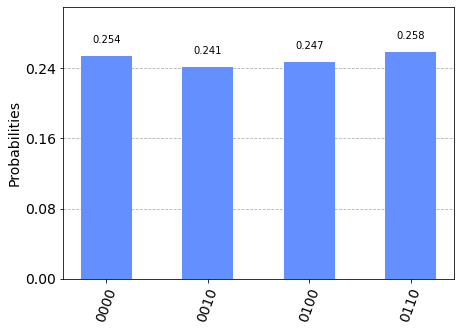

In [18]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

In [19]:
for z in counts:
    print( '{}.{} = {} (mod 2)'.format(s, z, bdotz(s, z)) )

1001.0000 = 0 (mod 2)
1001.0010 = 0 (mod 2)
1001.0100 = 0 (mod 2)
1001.0110 = 0 (mod 2)
